# Comparación de palabras iguales en poemas con emociones diferentes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import nltk
import we_to_signal as wes

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [3]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

In [4]:
emotion_a = "anger"
emotion_b = "anticipation"

mw2v_a = poems_w2v[emotion_a]
mfst_a = poems_fst[emotion_a]

mw2v_b = poems_w2v[emotion_b]
mfst_b = poems_fst[emotion_b]

In [5]:
def common_word(model_a,model_b)->list:
    """
    Create a list of common word in two gensim models.

    Parameters
    -------------
    model_a: Gensim model (fst or w2v).
    model_b: Gensim model (fst or w2v).

    Returns
    --------------
    list: List with common words between the models.
    """
    model_a_dict = model_a.wv.key_to_index
    model_b_dict = model_b.wv.key_to_index

    common_words = []
    for key in list(model_a_dict.keys()):
        if key in model_b_dict:
            common_words.append(key)
    
    return common_words

common_words_w2v = common_word(mw2v_a,mw2v_b)
common_words_fst = common_word(mfst_a,mfst_b)

In [6]:
def get_vectors(words:list,model)->list:
    """
    Calculate the embeddings of a list of strings gived a model.

    Parameters
    ------------
    words: List with strings.
    model: gensim model(fst or w2v)
    
    Returns
    ------------
    list: List with tuples of [word,vector].
    """

    vectors = []
    for word in words:
        vectors.append((word,model.wv.get_vector(word)))
    return vectors

In [7]:
def build_words_vectors_data(common_words:list,model_a,model_b)->pd.DataFrame:
    """
    Creates a Dataframe with columns [words, embbeding_model_a, embbeding_model_b]
    
    Parameters
    ------------
    common_words: list with common word between models.
    model_a: gensim model (fastext or w2v).
    model_b: gensim model (fastext or w2v).
    """

    data = {}
    data["words"] = common_words.copy()
    data["embbeding_model_a"] = []
    data["embbeding_model_b"] = []

    for word in common_words:
        data["embbeding_model_a"].append(model_a.wv.get_vector(word,norm=True))
        data["embbeding_model_b"].append(model_b.wv.get_vector(word,norm=True))

    return pd.DataFrame(data)

In [8]:
data_w2v = build_words_vectors_data(common_words_w2v,mw2v_a,mw2v_b)
data_fst = build_words_vectors_data(common_words_fst,mfst_a,mfst_b)

display(data_w2v)
display(data_fst)

,words,embbeding_model_a,embbeding_model_b
0,the,"[-0.074571356, 0.09888577, -0.035351947, 0.058...","[-0.12992264, 0.09067258, 0.0016633858, 0.0660..."
1,and,"[-0.076016836, 0.09836932, -0.0359653, 0.05484...","[-0.09529541, 0.14158711, 0.007732343, -0.0349..."
2,of,"[-0.07567521, 0.09813196, -0.037018374, 0.0551...","[-0.103375435, 0.124761075, -0.009955226, 0.01..."
3,a,"[-0.07517576, 0.09953175, -0.03721849, 0.05452...","[-0.10672734, 0.12793517, 0.005556323, 0.00644..."
4,to,"[-0.0747832, 0.09769986, -0.036672354, 0.05156...","[-0.041993607, 0.20082001, 0.0009315059, -0.09..."
...,...,...,...
8265,martyrs,"[-0.11708717, 0.18000051, -0.07979874, 0.10236...","[-0.09172351, 0.028397692, -0.036259986, -0.01..."
8266,elation,"[-0.056189828, 0.09017971, 0.060131565, 0.1171...","[0.043908708, 0.030624766, -0.10485483, 0.0380..."
8267,afternoons,"[0.060429826, -0.12160156, 0.07337983, -0.1498...","[-0.10714079, 0.15676244, 0.06014968, 0.108518..."
8268,gibberish,"[-0.009315444, 0.05983702, -0.09838189, 0.1613...","[-0.022979211, 0.18154301, -0.033790972, -0.00..."


,words,embbeding_model_a,embbeding_model_b
0,the,"[0.05892307, 0.038402352, -0.075489864, 0.0635...","[0.043330193, -0.010277707, -0.16763657, -0.00..."
1,and,"[0.059186235, 0.039017975, -0.073899955, 0.064...","[0.013457333, 0.028681222, -0.09165401, -0.027..."
2,of,"[0.061216712, 0.039325263, -0.075887546, 0.063...","[-0.009552455, 0.03292888, -0.0690358, -0.0304..."
3,a,"[0.059903935, 0.038734823, -0.07522733, 0.0629...","[0.03983606, 0.010796906, -0.09718523, -0.0059..."
4,to,"[0.060684998, 0.03858779, -0.07509665, 0.06213...","[0.074966714, 0.01745066, -0.041270588, 0.0064..."
...,...,...,...
1755,fortunes,"[0.060194585, 0.038032826, -0.07509847, 0.0634...","[0.047516268, 0.010357625, -0.06097739, 0.0037..."
1756,release,"[0.061862584, 0.03776, -0.07397126, 0.06235046...","[0.06364246, 0.003003505, -0.052978072, 0.0139..."
1757,decide,"[0.059682563, 0.039320666, -0.07605457, 0.0621...","[0.054955315, 0.008287174, -0.05922585, 0.0076..."
1758,bridges,"[0.060322605, 0.038319036, -0.074086666, 0.063...","[0.03656169, 0.013152264, -0.066844985, -0.003..."


In [9]:
word = "bring"

word_data = data_w2v[data_w2v["words"]==word]
word_data

,words,embbeding_model_a,embbeding_model_b
339,bring,"[-0.0688656, 0.09416714, -0.03821187, 0.053954...","[-0.05977244, 0.16778417, 0.009542436, -0.0438..."


In [10]:
print(word_data["embbeding_model_a"].values)

[array([-0.0688656 ,  0.09416714, -0.03821187,  0.05395499, -0.01844637,
        -0.2211572 ,  0.07139511,  0.28029686, -0.08197512, -0.11862894,
        -0.03529203, -0.1844964 , -0.04797777,  0.1167135 ,  0.08020385,
        -0.06601369,  0.08363637, -0.07533801,  0.00131319, -0.1951293 ,
         0.1019508 ,  0.06257318,  0.11337823, -0.07108132,  0.00257333,
        -0.01600572, -0.10341936, -0.05314986, -0.14204891,  0.05522308,
         0.16569097, -0.03880035,  0.03558872, -0.11911778, -0.06649421,
         0.10201389,  0.05073204, -0.04951679, -0.10054959, -0.22217542,
         0.01045941, -0.09135779, -0.051673  ,  0.03244301,  0.10582011,
        -0.06917658, -0.1120397 , -0.04529528,  0.06246192,  0.07548869,
         0.04870709, -0.07880032, -0.01240519, -0.04002517, -0.04369382,
         0.05379791,  0.04440226, -0.03455228, -0.11280337,  0.01228787,
         0.08759329, -0.03583346,  0.00696939, -0.02195072, -0.10176867,
         0.19567388,  0.01146567,  0.15209161, -0.2

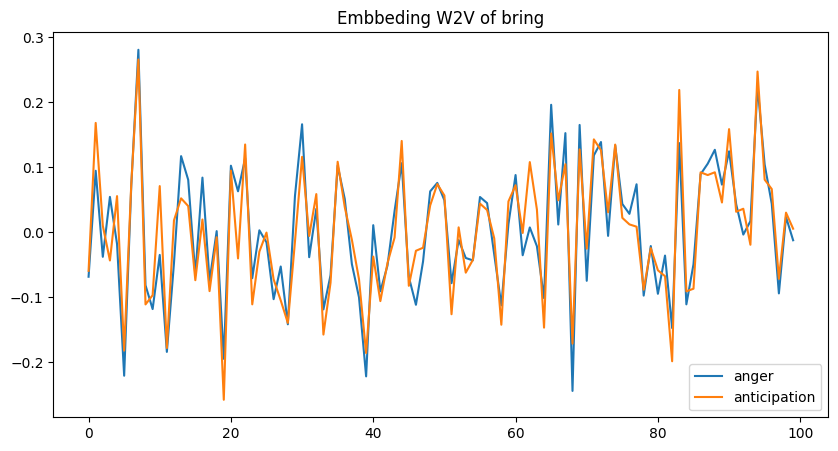

In [11]:
legend = [emotion_a,emotion_b]
plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(word_data["embbeding_model_a"].values[0])
plt.plot(word_data["embbeding_model_b"].values[0])
plt.legend(legend)

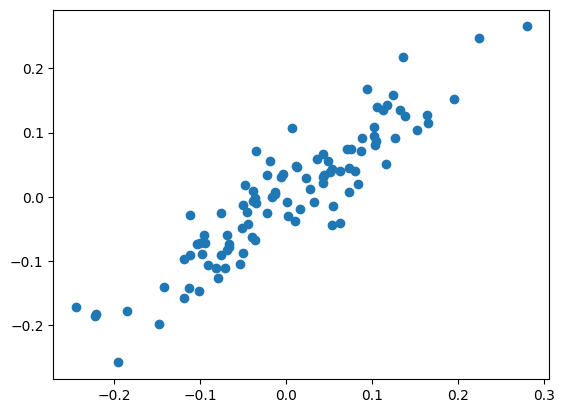

In [12]:
plt.scatter(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0])

In [13]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

display(spearmanr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))
display(pearsonr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))

SignificanceResult(statistic=0.9093309330933094, pvalue=4.209882109466041e-39)

PearsonRResult(statistic=0.9157850532955002, pvalue=1.3232929273565894e-40)

In [14]:
set_ = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_fst[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not set_:
        set_ = set_.union(intersection)
    else:
        set_ = set_.intersection(intersection)

display(len(set_))
display(set_)

677

{'a',
 'about',
 'above',
 'across',
 'act',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'ah',
 'air',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'am',
 'among',
 'amp',
 'an',
 'ancient',
 'and',
 'angels',
 'another',
 'answer',
 'any',
 'are',
 'arms',
 'around',
 'as',
 'ask',
 'at',
 'away',
 'b',
 'back',
 'bare',
 'be',
 'bear',
 'beauty',
 'because',
 'become',
 'bed',
 'been',
 'before',
 'begin',
 'behind',
 'behold',
 'being',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'between',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'both',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'but',
 'by',
 'call',
 'called',
 'came',
 'can',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'c

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
set_ = set_ - stop_words
set_

{'across',
 'act',
 'age',
 'ago',
 'ah',
 'air',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'among',
 'amp',
 'ancient',
 'angels',
 'another',
 'answer',
 'arms',
 'around',
 'ask',
 'away',
 'b',
 'back',
 'bare',
 'bear',
 'beauty',
 'become',
 'bed',
 'begin',
 'behind',
 'behold',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'call',
 'called',
 'came',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'clouds',
 'cold',
 'color',
 'come',
 'comes',
 'cool',
 'could',
 'country',
 'course',
 'cried',
 'cries',
 'cry',
 'cup',
 'cut',
 'dark',
 'day',
 'days',
 'dead',
 'dear',
 'death',
 'deep',
 'died',
 'dim',

In [16]:
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

In [17]:
def text_clean(sent):
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [18]:
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)
freq_dict

{'anger': Counter({'the': 5646,
          'and': 3318,
          'of': 2235,
          'a': 1857,
          'to': 1720,
          'in': 1642,
          'i': 1193,
          'that': 872,
          'with': 815,
          'is': 719,
          'his': 688,
          'my': 668,
          'on': 597,
          'for': 596,
          'you': 590,
          'he': 563,
          'it': 557,
          'not': 549,
          'but': 513,
          'words': 481,
          'all': 476,
          'as': 443,
          'at': 410,
          'from': 397,
          'was': 394,
          'me': 383,
          'they': 381,
          'their': 356,
          'by': 349,
          'like': 342,
          'are': 338,
          'your': 336,
          'or': 330,
          'be': 323,
          'her': 323,
          'we': 310,
          'so': 304,
          'this': 290,
          'when': 286,
          'an': 283,
          'no': 268,
          'what': 257,
          'have': 249,
          'will': 232,
          'one': 227,
 

In [19]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations

emotion_combinations = list(combinations(emotion_list,2))

words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_w2v[emotion_a].wv.get_vector(word,norm=True),poems_w2v[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_w2v_info = pd.DataFrame(words_embbed_info)
words_embbed_w2v_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,wind,85,184,27,167,203,230,48,146,"(0.889455469757067, 4.253806202751086e-35)",...,"(0.8241158914619279, 6.23555113441754e-26)","(0.8522380051996804, 2.5046890159685225e-29)","(0.8886895971344881, 5.853844888498677e-35)","(0.8672843812369407, 1.897276589547133e-31)","(0.8607772824465468, 1.6812923121179436e-30)","(0.8815087285787283, 1.0475924893121662e-33)","(0.8597452787379101, 2.352374929427311e-30)","(0.8887538988779754, 5.699519541523765e-35)","(0.8816499272640889, 9.916258405784554e-34)","(0.8695624637538695, 8.600315305036385e-32)"
1,wrong,26,56,8,45,54,50,6,78,"(0.8897656694025811, 3.7352904323367324e-35)",...,"(0.866040345591128, 2.9047082313670896e-31)","(0.8563293042497842, 7.016978829352851e-30)","(0.8709113417288269, 5.345598905042852e-32)","(0.8668588530020234, 2.1958909493906505e-31)","(0.8622942918588666, 1.021152664895023e-30)","(0.8428573874932292, 4.0291286003044723e-28)","(0.8660330063614708, 2.9119791309877755e-31)","(0.8640001846150928, 5.787243354291449e-31)","(0.8685352863192473, 1.2309579021780183e-31)","(0.884211033213065, 3.618251893317611e-34)"
2,many,75,220,26,113,229,219,18,281,"(0.9121083060228706, 9.814214382373782e-40)",...,"(0.8605220859007288, 1.8273485634384037e-30)","(0.8876103174550322, 9.143985306990427e-35)","(0.8867412993870772, 1.305155621207073e-34)","(0.8731236968826002, 2.4221518926973754e-32)","(0.8775887608584814, 4.680671233983141e-33)","(0.8720708063437009, 3.5368354174965624e-32)","(0.8658358977641306, 3.114038013064645e-31)","(0.9036498855149148, 7.190764151206701e-38)","(0.8987117085335046, 7.369975120513143e-37)","(0.8970311713368021, 1.5834168520950814e-36)"
3,lake,12,31,10,27,33,63,9,47,"(0.8844124191843739, 3.3391238346533925e-34)",...,"(0.8204714762536044, 1.5510334757458242e-25)","(0.8609326369048775, 1.598026906962212e-30)","(0.8891719069643113, 4.7889057737770855e-35)","(0.8565278483445624, 6.590214121865218e-30)","(0.856976439032719, 5.7171337902851945e-30)","(0.8725585596388291, 2.9691453478534204e-32)","(0.8439086812037625, 2.9783472849206768e-28)","(0.8789361793786098, 2.8144006019524018e-33)","(0.8785995652005961, 3.197589628517275e-33)","(0.8457668331348462, 1.736331674041119e-28)"
4,wood,16,53,7,42,46,55,11,52,"(0.8937912968357314, 6.668299584840643e-36)",...,"(0.8053191875269484, 5.5578671625433835e-24)","(0.8772963775085868, 5.222800725708685e-33)","(0.8847676237610259, 2.897191901404207e-34)","(0.881945276268682, 8.838390759499622e-34)","(0.8690554573277167, 1.0269403932123604e-31)","(0.8604411472629947, 1.8762070624252305e-30)","(0.8567484191396267, 6.1457886065605786e-30)","(0.9075848340407703, 1.0269175624437012e-38)","(0.8994136469744596, 5.33349642459469e-37)","(0.8902652548271971, 3.0272544575581567e-35)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,lay,37,112,25,83,116,137,19,139,"(0.8997039809474772, 4.6624571393301825e-37)",...,"(0.8622222856671259, 1.0457497318986133e-30)","(0.8824057640682654, 7.382258741654293e-34)","(0.8833474680636715, 5.09658868040325e-34)","(0.882465538338384, 7.2113492097258876e-34)","(0.8855993921577312, 2.073984790814519e-34)","(0.8969429342049695, 1.647688574245192e-36)","(0.8856903063847568, 1.9992625293646742e-34)","(0.9021318643690315, 1.489965034425371e-37)","(0.8888832223528109, 5.401082310259478e-35)","(0.8735826519602806, 2.0515135434892296e-32)"
558,others,22,69,12,57,76,66,7,99,"(0.912807810337351, 6.749503283966876e-40)",...,"(0.8745757953837694, 1.4289935469440051e-32)","(0.8849557074681604, 2.686879676335138e-34)","(0.8867231986011129, 1.3148236510512698e-34)","(0.87344318060529, 2.1578570741980047e-32)","(0.878083

In [20]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_fst[emotion_a].wv.get_vector(word,norm=True),poems_fst[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_fst_info = pd.DataFrame(words_embbed_info)
words_embbed_fst_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,wind,85,184,27,167,203,230,48,146,"(0.798225361619388, 2.6697962241210565e-23)",...,"(0.8270943019157642, 2.914901091879872e-26)","(0.7488220448900623, 3.3199457334598407e-19)","(0.8660249754000983, 2.9199556834380874e-31)","(0.7920273270794601, 1.000297911015219e-22)","(0.8220658405351239, 1.0437569381450164e-25)","(0.7449543009325487, 6.329559522698972e-19)","(0.7989880710453504, 2.2620776689659733e-23)","(0.6812605923099904, 6.187204809074656e-15)","(0.8226429054876345, 9.034717015621696e-26)","(0.7535723157848898, 1.4787485287827556e-19)"
1,wrong,26,56,8,45,54,50,6,78,"(0.8847234712841985, 2.9488462135125152e-34)",...,"(0.8934257690612974, 7.819761516712832e-36)","(0.8933675510741519, 8.020259172763688e-36)","(0.8727528540137756, 2.7687054603804687e-32)","(0.901231785459685, 2.2821562918904323e-37)","(0.8423330939686325, 4.680594162363477e-28)","(0.8394860053131575, 1.0463200482112915e-27)","(0.8787526488521191, 3.017392985755837e-33)","(0.8702987112997912, 6.638632464807098e-32)","(0.9090660842004531, 4.8251623384476784e-39)","(0.8912900511309163, 1.960772162730839e-35)"
2,many,75,220,26,113,229,219,18,281,"(0.8769422146249157, 5.962015360807378e-33)",...,"(0.8750140252165355, 1.2170514781699415e-32)","(0.9026261921869654, 1.176832581189473e-37)","(0.8728050251700167, 2.7171746496580335e-32)","(0.8907230375030226, 2.4947244540199967e-35)","(0.8162814268199589, 4.312254559219938e-25)","(0.7900119991114, 1.5222217733928672e-22)","(0.8477355162126338, 9.726512619688816e-29)","(0.893190556526921, 8.661160379017084e-36)","(0.8794017988934354, 2.3573869888665635e-33)","(0.8715312877317059, 4.288452425425441e-32)"
3,lake,12,31,10,27,33,63,9,47,"(0.8827633548109685, 6.415787076697854e-34)",...,"(0.8868304476691693, 1.2585438256531128e-34)","(0.8582509743468423, 3.807704800234859e-30)","(0.8760081975495362, 8.436488306751259e-33)","(0.8693233197349667, 9.351650338131219e-32)","(0.8503350249693428, 4.4682540289581085e-29)","(0.8409146030275919, 7.001973001971071e-28)","(0.8600110518305107, 2.1580107366354862e-30)","(0.8446768585776363, 2.384888480934195e-28)","(0.8852575575643282, 2.3801424403706763e-34)","(0.8603755510147078, 1.9167376245070478e-30)"
4,wood,16,53,7,42,46,55,11,52,"(0.8862276197009429, 1.6084638022177115e-34)",...,"(0.8893294390008196, 4.48400409874339e-35)","(0.8627354140012441, 8.823401849329496e-31)","(0.8753071090419842, 1.0927820219469591e-32)","(0.8933715604007091, 8.006291826363702e-36)","(0.8544082788478127, 1.2815088720393966e-29)","(0.8362555115487399, 2.558129085067678e-27)","(0.868577304766855, 1.2131055388982958e-31)","(0.8471907248696599, 1.1427661338164092e-28)","(0.882927587831448, 6.014443341466343e-34)","(0.8837090924921758, 4.416924073096256e-34)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,lay,37,112,25,83,116,137,19,139,"(0.8788794788867911, 2.875646052345219e-33)",...,"(0.8822497638374991, 7.847156585078247e-34)","(0.8682755373588272, 1.3471495717568238e-31)","(0.875282811441715, 1.1025945825598426e-32)","(0.8666147337825736, 2.3874248018056447e-31)","(0.8678182978600315, 1.5782294389764318e-31)","(0.8410337377161637, 6.770105423886448e-28)","(0.8602548455120529, 1.9935641843537994e-30)","(0.8602804522346057, 1.977018848399461e-30)","(0.8897753776905248, 3.7201019182453794e-35)","(0.8629364196500612, 8.253698440722726e-31)"
558,others,22,69,12,57,76,66,7,99,"(0.8812042613783485, 1.1789769898670124e-33)",...,"(0.8748463738195367, 1.2942340115442735e-32)","(0.8913170992530015, 1.9383097327176105e-35)","(0.8728131103706908, 2.7092729674688823e-32)","(0.8325723483557538, 6.925045315751182e-27)","(0.82

# Modulación de las palabras

In [21]:
#Muestra de la modulación

# Samples per second
sps = 44100

# Duration
duration_s = 5.0

In [22]:
# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 440.0
fm_hz = 220.0
k = 25.0

In [23]:
# First, define our range of sample numbers
each_sample_number = np.arange(duration_s * sps)

# Create the term that create the carrier
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

# Now create the term that is the frequency modulator
modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)

# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + modulator)
waveform_quiet = waveform * 0.3

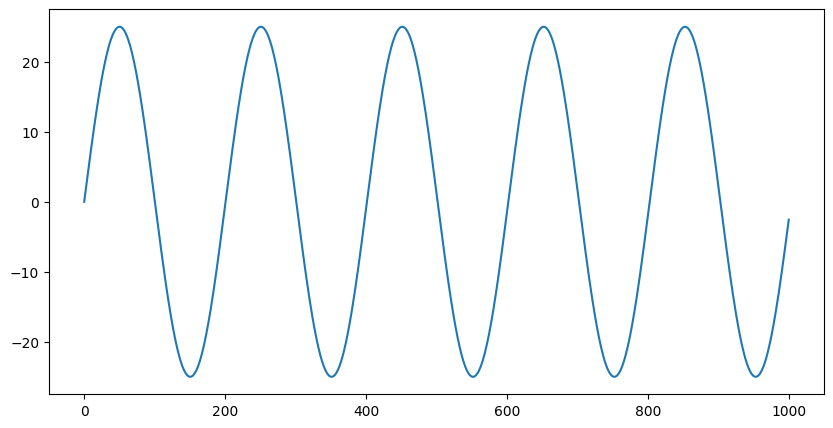

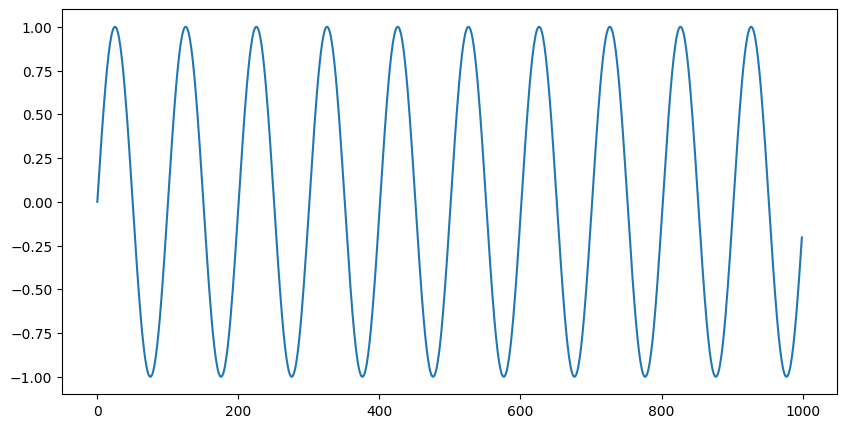

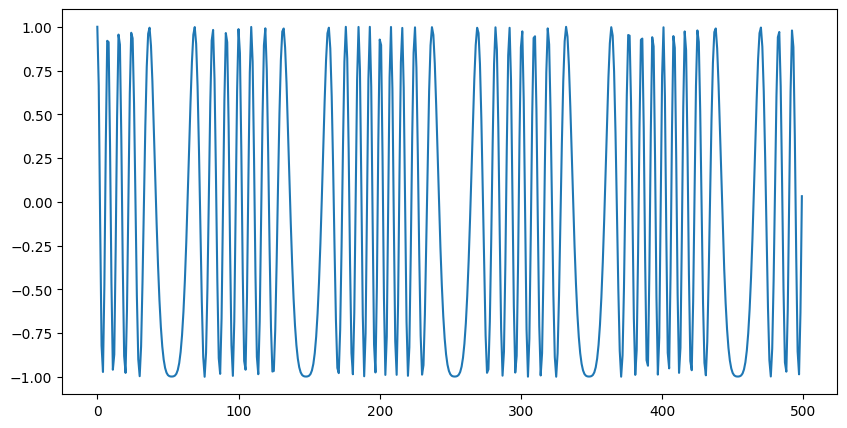

In [24]:
#Graphs
plt.figure(figsize=(10,5))
plt.plot(modulator[:1000])

plt.figure(figsize=(10,5))
plt.plot(np.sin(carrier[:1000]))

plt.figure(figsize=(10,5))
plt.plot(waveform[:500])

Muestra de embbeding modulado.

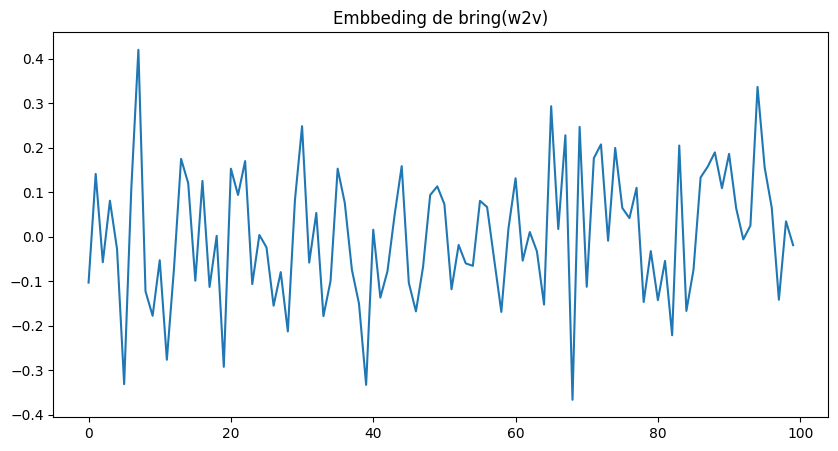

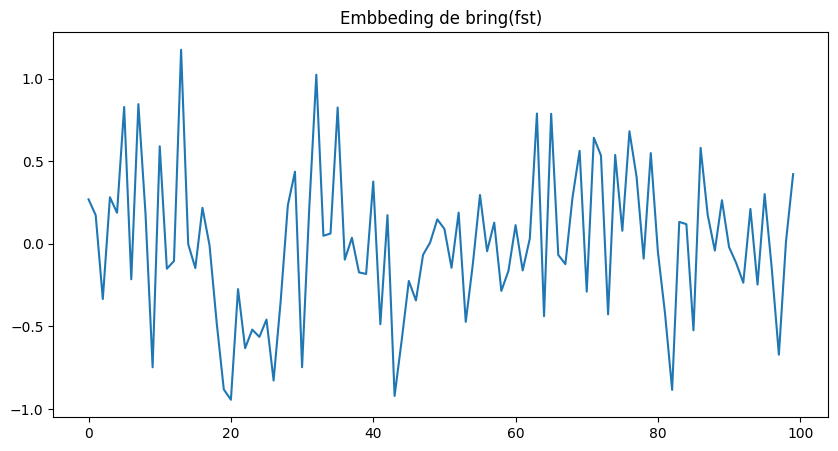

In [25]:
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word)
embbed_fst = poems_fst[emotion].wv.get_vector(word)

plt.figure(figsize=(10,5))
plt.title("Embbeding de "+word+"(w2v)")
plt.plot(embbed_w2v)

plt.figure(figsize=(10,5))
plt.title("Embbeding de "+word+"(fst)")
plt.plot(embbed_fst)

In [26]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 3.0
fm_hz = 50.0
k = 50


each_sample_number = np.arange(duration_s * sps)

carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

#modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)
modulator = embbed_w2v
# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + k*modulator)

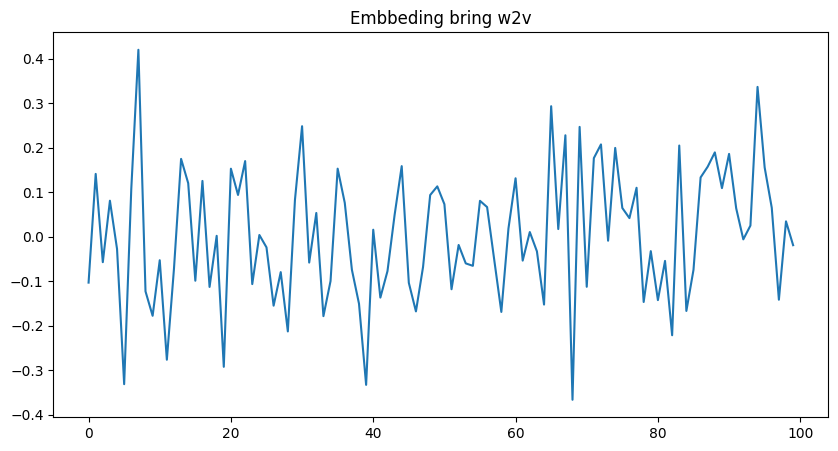

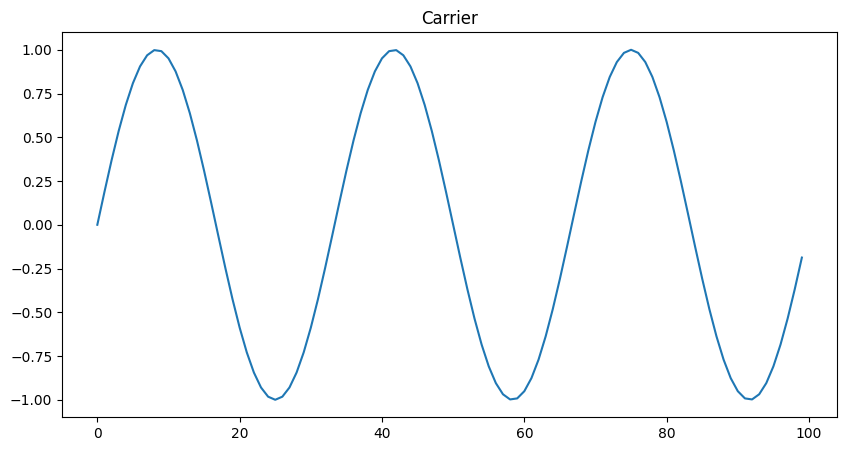

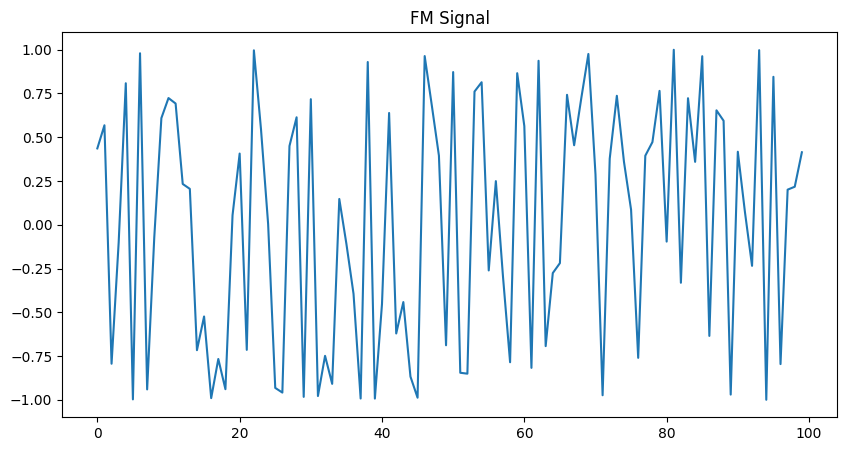

In [27]:
plt.figure(figsize=(10,5))
plt.title("Embbeding "+ word + " w2v")
plt.plot(embbed_w2v)

plt.figure(figsize=(10,5))
plt.title("Carrier")
plt.plot(np.sin(carrier))

plt.figure(figsize=(10,5))
plt.title("FM Signal")
plt.plot(waveform)

# Prueba de separación e impacto en la semántica.

In [28]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant

# Samples per second
sps = 100

# Duration
duration_s = 1.0

carrier_hz_a = 2
carrier_hz_b = 5
k = 50

words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_fst[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_fst[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

words_embbed_fst_mod = pd.DataFrame(words_embbed_info)
words_embbed_fst_mod

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,wind,85,184,27,167,203,230,48,146,"(0.03935154102461088, 0.6974843423305912)",...,"(0.008969149141579338, 0.929427134629488)","(0.10237134189098934, 0.3108173592656463)","(0.008994312679117837, 0.9292296491531822)","(0.09130861682228678, 0.36626289020368963)","(0.12439949683178332, 0.21751931379181666)","(0.0844988901260486, 0.40323277024258625)","(0.1348797765303468, 0.18090852809108082)","(-0.12746183991413793, 0.20631799687444108)","(0.009478218310581363, 0.9254327674468931)","(-0.03782002768248424, 0.708717512508033)"
1,wrong,26,56,8,45,54,50,6,78,"(-0.04404832941414095, 0.663448732223599)",...,"(-0.030844262877271378, 0.7606424594375544)","(0.027764655313315206, 0.7839242355179514)","(-0.04252622580738689, 0.6744081688723937)","(-0.052425785722956836, 0.6044421582965045)","(-0.015639146110129218, 0.8772670254851825)","(0.0054141118132988095, 0.9573647516886963)","(0.06892466493404922, 0.49562343116230473)","(0.02970594032788339, 0.769224539369022)","(-0.12795979621847492, 0.20453630791046465)","(-0.06164752879511737, 0.5423225478663073)"
2,many,75,220,26,113,229,219,18,281,"(0.03228910391196611, 0.7497912186628024)",...,"(-0.17753406050073978, 0.07721382334930833)","(0.0947848981887039, 0.3482206284205194)","(-0.11661118931147173, 0.2479276076791056)","(0.021271391511454223, 0.8336182468105732)","(-0.17622398554923283, 0.07945838341542452)","(-0.023891139436640504, 0.8134781786781069)","(0.07762690414644507, 0.4426839699404564)","(0.09791537008958417, 0.33245805262890366)","(0.014400726639835977, 0.8869187962875336)","(0.012040496256836517, 0.9053581714380042)"
3,lake,12,31,10,27,33,63,9,47,"(-0.05927153103598328, 0.5580241935888298)",...,"(0.03746518308510188, 0.7113292169370877)","(-0.027043208575438592, 0.7894068516538943)","(-0.07463420222951357, 0.46052125766297586)","(0.02808957092493341, 0.781458474989764)","(-0.09787873153169677, 0.33263986951216584)","(-0.05529153716310016, 0.5848033136094339)","(0.020902409168024418, 0.8364638814153207)","(0.021793806476985443, 0.8295929976350835)","(-0.0048046131643355566, 0.9621606848324573)","(0.01444153546645206, 0.8866004765793167)"
4,wood,16,53,7,42,46,55,11,52,"(-0.005933138368245154, 0.9532819029755526)",...,"(0.03213670756736303, 0.7509335104941565)","(-0.024529764786495826, 0.808586383695291)","(-0.07949802742827494, 0.43173223913314157)","(-0.10259972161132386, 0.30973345256461027)","(-0.025317940577089207, 0.8025592102628177)","(-0.03701138500622106, 0.7146740957059895)","(0.0025118528900671226, 0.9802122878221355)","(0.022494686414015516, 0.8241995898100456)","(-0.07567261231119077, 0.45428764528592597)","(0.041325369585084315, 0.6831029596715616)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,lay,37,112,25,83,116,137,19,139,"(-0.0661840607783775, 0.5129587999756906)",...,"(0.004708079381254387, 0.962920403732166)","(-0.04509178361467453, 0.6559762437738232)","(-0.10764098176621484, 0.2864338468975661)","(0.1096371802278545, 0.2775387456116744)","(-0.01526308588864986, 0.8801960637418572)","(-0.12194760140802298, 0.22679308520745042)","(0.07548334702277104, 0.45542030908198217)","(0.01127242973788123, 0.9113700531174769)","(0.03706721408815951, 0.7142622950299601)","(-0.005775099575120079, 0.9545249697590501)"
558,others,22,69,12,57,76,66,7,99,"(0.01729881643901423, 0.8643605523640987)",...,"(0.11048474626166185, 0.27381860658230855)","(-0.0003571830821830673, 0.9971859279123623)","(-0.11426696768803066, 0.25762778158787725)","(0.09497308268091893, 0.34726007414131754)","(0.065305142165389, 0.5185834233477657)","(0.042170467158181305, 0.6769796411872288)","(0.039478555960

In [29]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

words_embbed_w2v_mod = pd.DataFrame(words_embbed_info)
words_embbed_w2v_mod

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,wind,85,184,27,167,203,230,48,146,"(-0.03131762115872763, 0.7570821542267818)",...,"(0.11451870279165843, 0.25657387577603474)","(0.013532727559235937, 0.8936935944871323)","(-0.08219599855850322, 0.4162164065331535)","(0.011196589270483292, 0.9119639553680802)","(0.07274574857921873, 0.4719774715954337)","(0.0869489977313846, 0.3896848773365653)","(-0.03604685888017712, 0.7218013561951575)","(0.046270808569307605, 0.6475735311532438)","(-0.14917816800737915, 0.1385190015639262)","(0.003260015616472556, 0.9743202340665931)"
1,wrong,26,56,8,45,54,50,6,78,"(0.08435428032351683, 0.40404097754540913)",...,"(-0.05575065966410047, 0.5816843223592553)","(0.07171897405821852, 0.47827064414662884)","(-0.08878969606052682, 0.3796883720676465)","(0.13611219938114322, 0.1769188980178806)","(0.010115033803348661, 0.920438665928011)","(-0.07025641145107701, 0.4873122010072109)","(-0.1746934244284801, 0.08214653678421337)","(0.03610823457545354, 0.7213471104561305)","(-0.13443992423525686, 0.18234823589896634)","(-0.10711113086297806, 0.2888263619802307)"
2,many,75,220,26,113,229,219,18,281,"(0.004771973736345831, 0.9624175527123277)",...,"(-0.04654274125329505, 0.6456417224529188)","(0.061775188280722385, 0.541485098458209)","(0.0058037870532737755, 0.9542993179238467)","(0.0290049804020977, 0.774523197167591)","(0.005614277217807828, 0.9557900426899806)","(0.029339236143824228, 0.7719952030448088)","(-0.04749343787654309, 0.638906524745523)","(-0.0928460563485228, 0.3582137308478284)","(-0.023185796902632894, 0.8188893499318184)","(-0.15405751361322992, 0.12592818674808942)"
3,lake,12,31,10,27,33,63,9,47,"(-0.04909539717051651, 0.6276237497654023)",...,"(0.016734190510939273, 0.8687475600272041)","(0.0026883504655081224, 0.97882219761819)","(-0.0823034523908827, 0.4156052344871329)","(0.04824432805369558, 0.6336074675437149)","(0.013719210510149262, 0.8922374197289791)","(0.025615782788380618, 0.800284600232446)","(-0.033252478069898075, 0.7425828074094953)","(-0.01169657389461032, 0.9080495128812022)","(-0.1754726560000043, 0.08076902327581863)","(0.06641827315372736, 0.5114652607548095)"
4,wood,16,53,7,42,46,55,11,52,"(-0.052861746338703414, 0.6014358067543373)",...,"(0.16356960678041985, 0.10392771394198644)","(0.061111176881589374, 0.5458479622613469)","(-0.0070426993634721885, 0.9445578804380381)","(-0.01943424754225248, 0.8478070493198592)","(0.12738909012160093, 0.20657922200903553)","(0.02509633680253634, 0.8042526605683387)","(-0.0791031705211543, 0.4340303883877231)","(-0.10013994641688312, 0.3215372179507182)","(-0.06240114147615721, 0.537388053270603)","(-0.1702967972770166, 0.09027385448419231)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,lay,37,112,25,83,116,137,19,139,"(-0.11250300666091212, 0.2650956498063967)",...,"(-0.019855364949549627, 0.8445501700406881)","(0.08616760729156885, 0.393975680987054)","(0.013747682116138624, 0.8920151270914688)","(0.044647912157876744, 0.659150852955361)","(0.10671500691568023, 0.29062367743898193)","(-0.060943197135489034, 0.5469543810763751)","(-0.18756107866165667, 0.06167154303988277)","(-0.03213437922965821, 0.7509509668027678)","(-0.18701697393203182, 0.06244381940252411)","(-0.09675766018221497, 0.33823367251501224)"
558,others,22,69,12,57,76,66,7,99,"(0.08311812844600991, 0.41098855465413986)",...,"(-0.07304231937758252, 0.4701681680717958)","(0.053389196706249295, 0.5978074589402047)","(-0.011676422883802646, 0.9082072358053241)","(0.07362155206156898, 0.46664532024005434)","(-0.10077037052339155, 0.3184847854466929)","(-0.0486553482025755, 0.63071467931642)","(-0.062032959181970326, 

In [30]:
#Información de correlacion datos modulados.
pearsonr_mod_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_mod_data_w2v[comb] = [data[0] for data in words_embbed_w2v_mod["P_"+str(comb)]]

pearsonr_mod_data_fst = {}

for comb in emotion_combinations:
    pearsonr_mod_data_fst[comb] = [data[0] for data in words_embbed_fst_mod["P_"+str(comb)]]

#Información de correlacion datos no modulados.
pearsonr_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_w2v_info["P_"+str(comb)]]

pearsonr_data_fst = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_fst_info["P_"+str(comb)]]


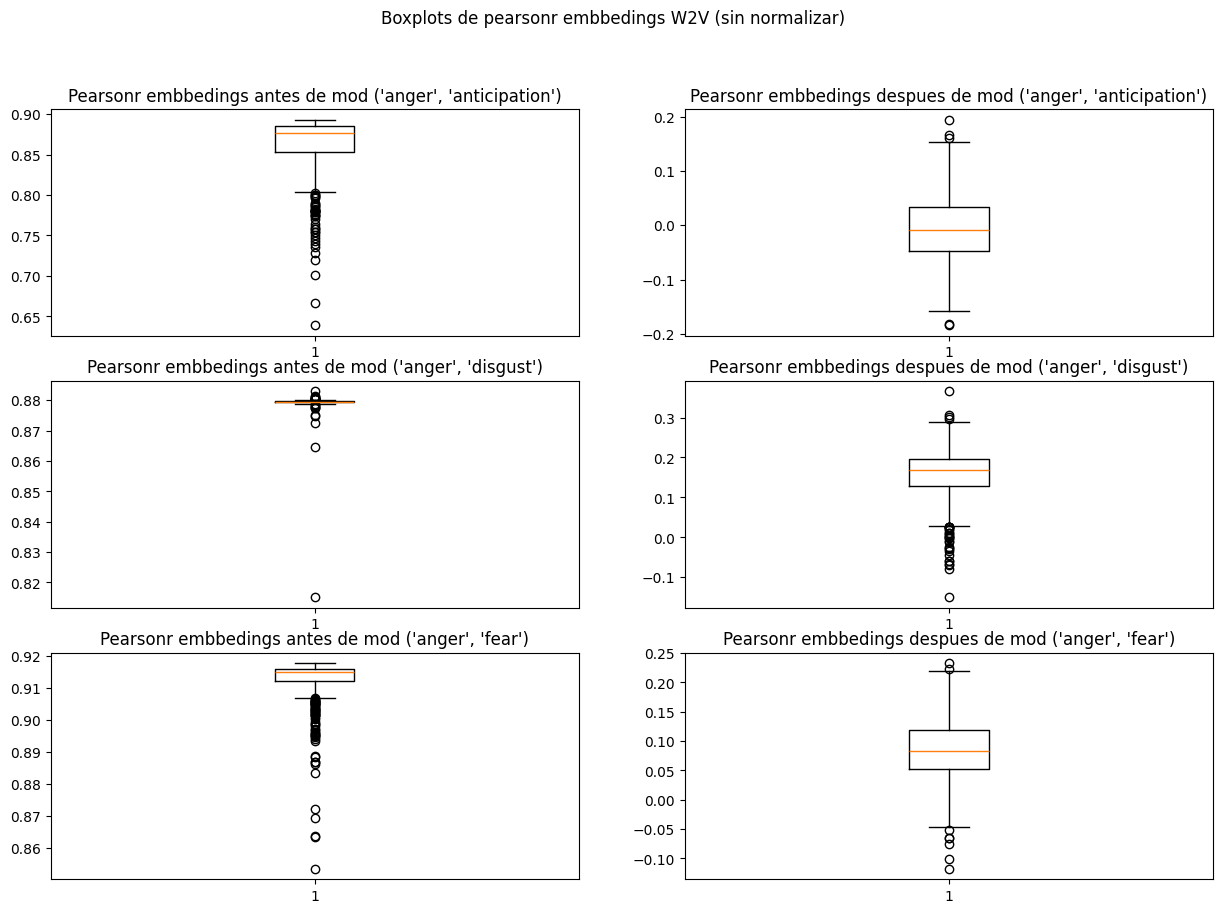

In [31]:
fig,ax = plt.subplots(3,2,figsize=(15,10))

fig.suptitle("Boxplots de pearsonr embbedings W2V (sin normalizar)")
for i in range(3):
    comb = emotion_combinations[i]
    ax[i,0].set_title("Pearsonr embbedings antes de mod "+str(comb))
    ax[i,0].boxplot(pearsonr_data_w2v[comb])

    ax[i,1].set_title("Pearsonr embbedings despues de mod "+str(comb))
    ax[i,1].boxplot(pearsonr_mod_data_w2v[comb])
plt.show()

In [33]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_fst[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_fst[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        fm_embbed_a_normalized = fm_embbed_a / np.sqrt(np.sum(fm_embbed_a**2))
        fm_embbed_b_normalized = fm_embbed_b / np.sqrt(np.sum(fm_embbed_b**2))

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a_normalized,fm_embbed_b_normalized))

words_embbed_fst_mod_norm = pd.DataFrame(words_embbed_info)
words_embbed_fst_mod_norm

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,wind,85,184,27,167,203,230,48,146,"(0.03935154102461085, 0.6974843423305912)",...,"(0.008969149141579306, 0.929427134629488)","(0.10237134189098929, 0.3108173592656463)","(0.008994312679117806, 0.9292296491531822)","(0.09130861682228675, 0.36626289020368963)","(0.12439949683178327, 0.2175193137918175)","(0.0844988901260486, 0.40323277024258625)","(0.13487977653034686, 0.18090852809108082)","(-0.12746183991413793, 0.20631799687444108)","(0.009478218310581396, 0.9254327674468914)","(-0.03782002768248424, 0.708717512508033)"
1,wrong,26,56,8,45,54,50,6,78,"(-0.04404832941414093, 0.663448732223599)",...,"(-0.030844262877271364, 0.7606424594375544)","(0.027764655313315192, 0.7839242355179514)","(-0.04252622580738682, 0.6744081688723937)","(-0.05242578572295681, 0.6044421582965045)","(-0.015639146110129246, 0.8772670254851825)","(0.005414111813298822, 0.9573647516886963)","(0.06892466493404922, 0.49562343116230473)","(0.029705940327883384, 0.769224539369022)","(-0.12795979621847497, 0.20453630791046465)","(-0.06164752879511738, 0.542322547866306)"
2,many,75,220,26,113,229,219,18,281,"(0.032289103911966155, 0.7497912186628024)",...,"(-0.17753406050073978, 0.07721382334930833)","(0.09478489818870392, 0.3482206284205194)","(-0.11661118931147173, 0.2479276076791056)","(0.021271391511454237, 0.8336182468105732)","(-0.17622398554923285, 0.07945838341542452)","(-0.0238911394366405, 0.8134781786781069)","(0.0776269041464451, 0.4426839699404564)","(0.0979153700895842, 0.33245805262890366)","(0.014400726639835998, 0.8869187962875336)","(0.012040496256836494, 0.9053581714380042)"
3,lake,12,31,10,27,33,63,9,47,"(-0.05927153103598329, 0.5580241935888298)",...,"(0.03746518308510187, 0.7113292169370877)","(-0.027043208575438564, 0.7894068516538943)","(-0.07463420222951356, 0.46052125766297586)","(0.028089570924933385, 0.781458474989764)","(-0.09787873153169671, 0.33263986951216584)","(-0.0552915371631002, 0.5848033136094339)","(0.02090240916802441, 0.8364638814153207)","(0.02179380647698543, 0.8295929976350835)","(-0.004804613164335506, 0.9621606848324573)","(0.014441535466452056, 0.8866004765793167)"
4,wood,16,53,7,42,46,55,11,52,"(-0.00593313836824514, 0.9532819029755526)",...,"(0.03213670756736304, 0.7509335104941565)","(-0.02452976478649583, 0.808586383695291)","(-0.07949802742827497, 0.4317322391331394)","(-0.10259972161132389, 0.30973345256461027)","(-0.02531794057708917, 0.8025592102628177)","(-0.03701138500622111, 0.7146740957059895)","(0.0025118528900671244, 0.9802122878221355)","(0.02249468641401553, 0.8241995898100456)","(-0.07567261231119075, 0.45428764528592597)","(0.041325369585084315, 0.6831029596715616)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,lay,37,112,25,83,116,137,19,139,"(-0.06618406077837753, 0.5129587999756906)",...,"(0.004708079381254439, 0.962920403732166)","(-0.04509178361467456, 0.6559762437738232)","(-0.10764098176621482, 0.28643384689756723)","(0.10963718022785449, 0.2775387456116744)","(-0.015263085888649854, 0.8801960637418572)","(-0.1219476014080229, 0.22679308520745042)","(0.07548334702277103, 0.4554203090819827)","(0.011272429737881218, 0.9113700531174769)","(0.03706721408815949, 0.7142622950299622)","(-0.005775099575120053, 0.9545249697590501)"
558,others,22,69,12,57,76,66,7,99,"(0.01729881643901425, 0.8643605523640987)",...,"(0.11048474626166187, 0.27381860658230855)","(-0.00035718308218307595, 0.9971859279123623)","(-0.11426696768803063, 0.25762778158787725)","(0.09497308268091896, 0.34726007414131754)","(0.06530514216538896, 0.5185834233477657)","(0.04217046715818133, 0.6769796411872288)","(0.03947855596095666,

In [34]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        fm_embbed_a_normalized = fm_embbed_a / np.sqrt(np.sum(fm_embbed_a**2))
        fm_embbed_b_normalized = fm_embbed_b / np.sqrt(np.sum(fm_embbed_b**2))

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a_normalized,fm_embbed_b_normalized))

words_embbed_w2v_mod_norm = pd.DataFrame(words_embbed_info)
words_embbed_w2v_mod_norm

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,wind,85,184,27,167,203,230,48,146,"(-0.031317621158727674, 0.7570821542267818)",...,"(0.11451870279165843, 0.25657387577603474)","(0.013532727559235957, 0.89369359448713)","(-0.08219599855850325, 0.4162164065331535)","(0.011196589270483307, 0.9119639553680802)","(0.07274574857921876, 0.4719774715954337)","(0.08694899773138463, 0.3896848773365653)","(-0.03604685888017713, 0.7218013561951575)","(0.04627080856930759, 0.6475735311532438)","(-0.14917816800737918, 0.1385190015639262)","(0.0032600156164725646, 0.9743202340665931)"
1,wrong,26,56,8,45,54,50,6,78,"(0.08435428032351683, 0.40404097754540913)",...,"(-0.055750659664100435, 0.5816843223592553)","(0.07171897405821852, 0.47827064414662884)","(-0.08878969606052682, 0.3796883720676465)","(0.1361121993811432, 0.1769188980178806)","(0.010115033803348657, 0.920438665928011)","(-0.07025641145107696, 0.4873122010072122)","(-0.17469342442848004, 0.08214653678421337)","(0.036108234575453584, 0.7213471104561305)","(-0.13443992423525689, 0.18234823589896612)","(-0.10711113086297805, 0.2888263619802307)"
2,many,75,220,26,113,229,219,18,281,"(0.004771973736345865, 0.9624175527123277)",...,"(-0.04654274125329505, 0.6456417224529188)","(0.06177518828072236, 0.5414850984582091)","(0.005803787053273741, 0.9542993179238467)","(0.029004980402097723, 0.774523197167591)","(0.005614277217807858, 0.9557900426899806)","(0.02933923614382422, 0.7719952030448088)","(-0.04749343787654309, 0.638906524745523)","(-0.0928460563485228, 0.3582137308478284)","(-0.023185796902632866, 0.8188893499318189)","(-0.15405751361322995, 0.12592818674808867)"
3,lake,12,31,10,27,33,63,9,47,"(-0.04909539717051651, 0.6276237497654023)",...,"(0.016734190510939252, 0.8687475600272041)","(0.002688350465508131, 0.97882219761819)","(-0.08230345239088271, 0.4156052344871329)","(0.04824432805369559, 0.6336074675437149)","(0.013719210510149231, 0.8922374197289782)","(0.025615782788380653, 0.800284600232446)","(-0.0332524780698981, 0.7425828074094953)","(-0.011696573894610316, 0.9080495128812027)","(-0.17547265600000436, 0.08076902327581863)","(0.06641827315372736, 0.5114652607548095)"
4,wood,16,53,7,42,46,55,11,52,"(-0.05286174633870342, 0.6014358067543373)",...,"(0.16356960678041985, 0.10392771394198644)","(0.061111176881589374, 0.5458479622613469)","(-0.007042699363472196, 0.9445578804380381)","(-0.01943424754225254, 0.8478070493198571)","(0.1273890901216009, 0.20657922200903553)","(0.02509633680253635, 0.8042526605683387)","(-0.07910317052115431, 0.4340303883877231)","(-0.1001399464168831, 0.3215372179507182)","(-0.06240114147615718, 0.537388053270603)","(-0.17029679727701663, 0.09027385448419231)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,lay,37,112,25,83,116,137,19,139,"(-0.11250300666091215, 0.2650956498063967)",...,"(-0.019855364949549613, 0.8445501700406881)","(0.08616760729156883, 0.393975680987054)","(0.01374768211613863, 0.8920151270914688)","(0.04464791215787675, 0.659150852955361)","(0.10671500691568019, 0.29062367743898193)","(-0.06094319713548903, 0.5469543810763751)","(-0.18756107866165672, 0.061671543039882475)","(-0.03213437922965825, 0.7509509668027678)","(-0.18701697393203182, 0.06244381940252411)","(-0.09675766018221496, 0.33823367251501224)"
558,others,22,69,12,57,76,66,7,99,"(0.0831181284460099, 0.41098855465413986)",...,"(-0.0730423193775825, 0.4701681680717958)","(0.053389196706249295, 0.5978074589402047)","(-0.011676422883802664, 0.9082072358053241)","(0.073621552061569, 0.46664532024005434)","(-0.10077037052339156, 0.3184847854466929)","(-0.0486553482025755, 0.63071467931642)","(-0.06203295918197027, 0.53979

In [37]:
pearsonr_mod_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_mod_data_w2v[comb] = [data[0] for data in words_embbed_w2v_mod["P_"+str(comb)]]

pearsonr_mod_data_fst = {}

for comb in emotion_combinations:
    pearsonr_mod_data_fst[comb] = [data[0] for data in words_embbed_fst_mod["P_"+str(comb)]]

#Información de correlacion datos no modulados.
pearsonr_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_w2v_info["P_"+str(comb)]]

pearsonr_data_fst = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_fst_info["P_"+str(comb)]]

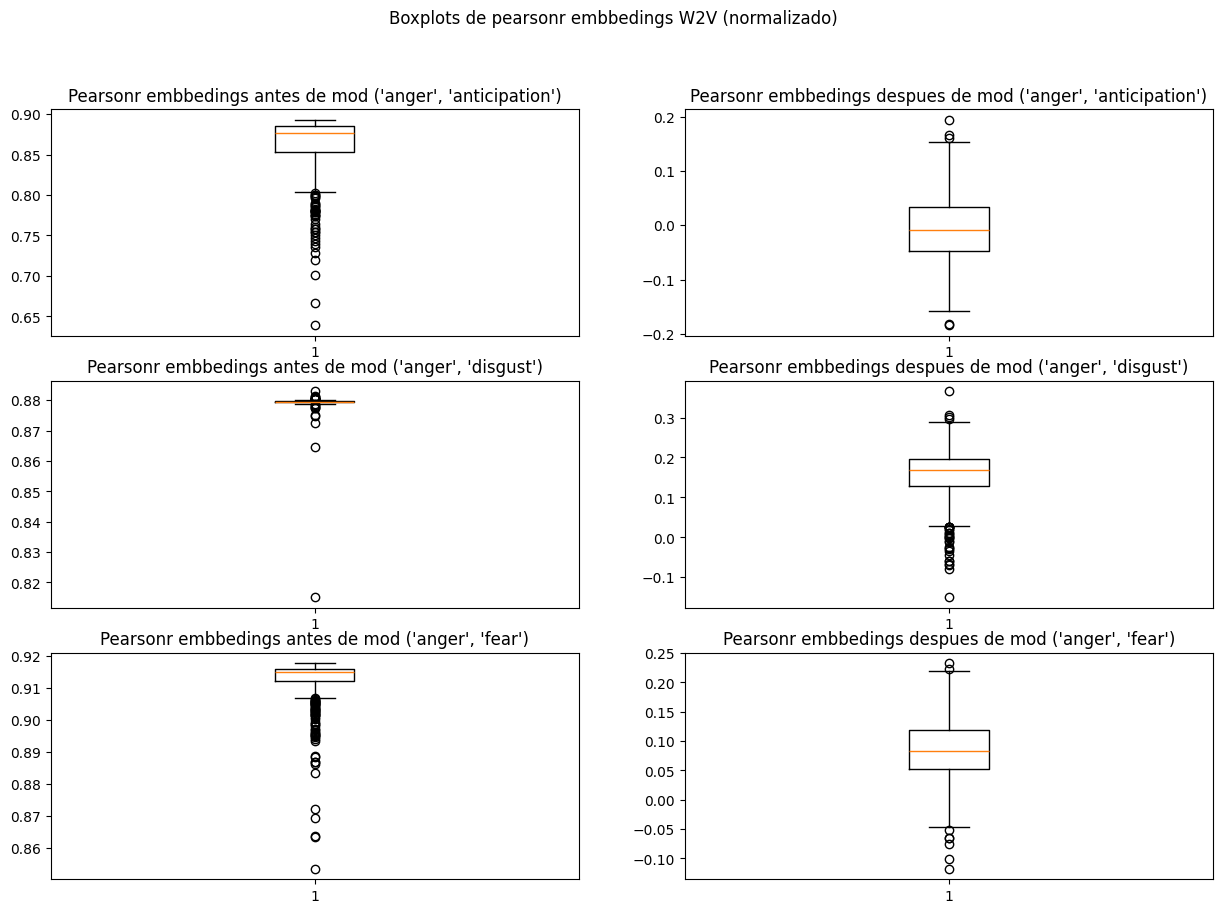

In [38]:
fig,ax = plt.subplots(3,2,figsize=(15,10))

fig.suptitle("Boxplots de pearsonr embbedings W2V (normalizado)")
for i in range(3):
    comb = emotion_combinations[i]
    ax[i,0].set_title("Pearsonr embbedings antes de mod "+str(comb))
    ax[i,0].boxplot(pearsonr_data_w2v[comb])

    ax[i,1].set_title("Pearsonr embbedings despues de mod "+str(comb))
    ax[i,1].boxplot(pearsonr_mod_data_w2v[comb])
plt.show()

## Análisis de impacto en la sémantica.